In [ ]:
from pathlib import Path
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

### Inspecting Individual Image

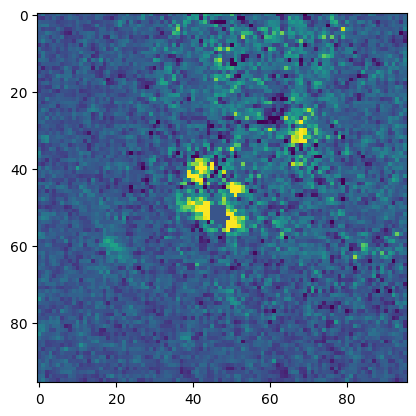

In [45]:
# TILE102159778_2736226726667554506
# TILE102159492_2765663487667132260
for item in content:
    if 'TILE102019124_-578501749504840211' in item: 
        item = Image.open(item)
        array = np.array(item)
        plt.imshow(item)

### Generate a list of the absolute paths of original cutouts

In [2]:
original_cutout_path = Path('/home/xinmeix/ml_cutouts/final_cutout')
original_cutout_list = []
for cutout in original_cutout_path.iterdir():
    original_cutout_list.append(str(cutout))

### Convert images to arrays for later processing (3 min estimate)

In [49]:
img_array_list = []
for i,img in enumerate(original_cutout_list):
    img = Image.open(img)
    img_array = np.array(img)
    # img_array = cp.asarray(img_array)
    img_array_list.append(img_array)

    if i%10000==0:
        print(f'Completed: {i}/541907')

Completed: 0/541907
Completed: 1000/541907
Completed: 2000/541907
Completed: 3000/541907
Completed: 4000/541907
Completed: 5000/541907
Completed: 6000/541907
Completed: 7000/541907
Completed: 8000/541907
Completed: 9000/541907
Completed: 10000/541907
Completed: 11000/541907
Completed: 12000/541907
Completed: 13000/541907
Completed: 14000/541907
Completed: 15000/541907
Completed: 16000/541907
Completed: 17000/541907
Completed: 18000/541907
Completed: 19000/541907
Completed: 20000/541907
Completed: 21000/541907
Completed: 22000/541907
Completed: 23000/541907
Completed: 24000/541907
Completed: 25000/541907
Completed: 26000/541907
Completed: 27000/541907
Completed: 28000/541907
Completed: 29000/541907
Completed: 30000/541907
Completed: 31000/541907
Completed: 32000/541907
Completed: 33000/541907
Completed: 34000/541907
Completed: 35000/541907
Completed: 36000/541907
Completed: 37000/541907
Completed: 38000/541907
Completed: 39000/541907
Completed: 40000/541907
Completed: 41000/541907
Compl

### Setting thresholds for removing artifacts (CPU)

In [54]:
def noise(img_array):
    noisy = (np.mean(img_array[:,:-32])>70 and np.mean(img_array[:,:-32])<120)
    light_center = np.mean(img_array[38:52,32:48]) > 150 
    if noisy and not light_center:
        return True 

In [55]:
def large_defect(img_array):
    
    step = 1 
    size = 6
    
    for v in range(int((len(img_array)-size)/step)+1):
        v_start = v * step 
        v_end = v_start + size 
        # print(f'V: {v_start},{v_end}')

        for h in range(int((len(img_array[0])-size)/step)+1):
            h_start = h * step
            h_end = h_start + size 
            # print(f'H: {h_start},{h_end}')

            region = img_array[v_start:v_end,h_start:h_end]
            is_same = len(np.unique(region)) == 1
            is_dark = np.all(region < 150)
            if is_same and is_dark:
                return True   

In [56]:
def small_defect(img_array):
    center_v_range = range(43, 53)
    center_h_range = range(43, 53)
    for c_v in center_v_range:
        for c_h in center_h_range:
            cv_start = c_v
            cv_end = cv_start + 2
            ch_start = c_h
            ch_end = ch_start + 2
            
            region = img_array[cv_start:cv_end, ch_start:ch_end]
            is_same = len(np.unique(region)) == 1
            is_dark = np.all(region < 150)
            
            if is_same and is_dark:
                return True

### Setting thresholds for removing artifacts (GPU)

In [35]:
def noise_gpu(img_array):
    noisy = (cp.mean(img_array[:,:-32])>70 and cp.mean(img_array[:,:-32])<120)
    light_center = cp.mean(img_array[38:52,32:48]) > 150 
    if noisy and not light_center:
        return True 

In [36]:
def large_defect_gpu(img_array):
    step = 1 
    size = 6
    
    for v in range(int((len(img_array)-size)/step)+1):
        v_start = v * step 
        v_end = v_start + size 

        for h in range(int((len(img_array[0])-size)/step)+1):
            h_start = h * step
            h_end = h_start + size 

            region = img_array[v_start:v_end,h_start:h_end]
            is_same = cp.unique(region).size == 1
            is_dark = cp.all(region < 150)
            if is_same and is_dark:
                return True 

In [37]:
def small_defect_gpu(img_array):
    center_v_range = range(43, 53)
    center_h_range = range(43, 53)

    for c_v in center_v_range:
        for c_h in center_h_range:
            cv_start = c_v
            cv_end = cv_start + 2
            ch_start = c_h
            ch_end = ch_start + 2
            
            region = img_array[cv_start:cv_end, ch_start:ch_end]
            is_same = cp.unique(region).size == 1
            is_dark = cp.all(region < 150)
            
            if is_same and is_dark:
                return True

### Remove artifact images and store the remaining in a list

In [58]:
cutout_index = []
for i in range(len(original_cutout_list)):
    cutout_index.append(i)

In [59]:
noisy_count = 0
small_defect_count = 0
large_defect_count = 0
for i,item in enumerate(img_array_list):
    if noise(item):
        cutout_index.remove(i)
        noisy_count += 1
    elif large_defect(item):
        cutout_index.remove(i)
        large_defect_count += 1 
    elif small_defect(item):
        cutout_index.remove(i)
        small_defect_count += 1

    if i%10000 == 0:
        print(f'Completed: {i}/541907')

Completed: 0/541907
Completed: 10000/541907
Completed: 20000/541907
Completed: 30000/541907
Completed: 40000/541907
Completed: 50000/541907
Completed: 60000/541907
Completed: 70000/541907
Completed: 80000/541907
Completed: 90000/541907
Completed: 100000/541907
Completed: 110000/541907
Completed: 120000/541907
Completed: 130000/541907
Completed: 140000/541907
Completed: 150000/541907
Completed: 160000/541907
Completed: 170000/541907
Completed: 180000/541907
Completed: 190000/541907
Completed: 200000/541907
Completed: 210000/541907
Completed: 220000/541907
Completed: 230000/541907
Completed: 240000/541907
Completed: 250000/541907
Completed: 260000/541907
Completed: 270000/541907
Completed: 280000/541907
Completed: 290000/541907
Completed: 300000/541907
Completed: 310000/541907
Completed: 320000/541907
Completed: 330000/541907
Completed: 340000/541907
Completed: 350000/541907
Completed: 360000/541907
Completed: 370000/541907
Completed: 380000/541907
Completed: 390000/541907
Completed: 400

In [60]:
print(f'Noisy image count: {noisy_count}')
print(f'Small defection count: {small_defect_count}')
print(f'Large defection count: {large_defect_count}')

Noisy image count: 38833
Small defection count: 3931
Large defection count: 2589


In [61]:
cleaned_cutout_path = []
for i in range(len(original_cutout_list)):
    if i in cutout_index:
        cleaned_cutout_path.append(original_cutout_list[i])

### Copy the selected cleaned cutouts to a new directory

In [62]:
des_dir = '/home/xinmeix/ml_cutouts/cleaned_cutout'
for file_path in cleaned_cutout_path:
    if os.path.isfile(file_path):
        shutil.copy(file_path,des_dir)
print('All cleaned cutouts copied successfully.')

All cleaned cutouts copied successfully.
